## BeamformerEA demo notebook
This notebook demonstartes the use of the BeamformerEA acoular class. The BeamformerEA reconstructs 
an acoustic field using monopole sound sources. Unlike the other beamformer in acoular, it uses a variable grid to reconstruct the sources. It can correctly find the positions and the source strengths. To achieve this goal, a global optimization problem is solved using the evolutionary algorithm differential evolution from the scipyt.optimice python package. 

Below is a synthetic data set with a monopole acoustic source evaluated with BeamformerEA, BeamformerBase and BeamformerCMF. The monoopole source shall be positioned at x_s = 0.5, y_s = 0.0, z_s = 0.75 with a rms amplitude of 1.0 in 1 m distance. The variable search gird for the source shall be defined on the x,y - surface with bounds:  x = [-1.0, 1.0] y = [-1.0, 1.0] z = [0.75, 0.75] d = [0.0, 1.0]. Where d are the bounds for the source strength. 

In [1]:
from acoular import *
from os import path
from acoular import __file__ as bpath
import matplotlib.pyplot as plt

# load some array geometry
micgeofile = path.join(path.split(bpath)[0], 'xml', 'array_64.xml')
micgeom = MicGeom(from_file=micgeofile) 

# set sampling frequency and singal time 
sfreq = 51200
time = 1
num_samples = time * sfreq
block_size = 128 # small block_size for fewer small band frequencies

# create some exemplary synthetic data of one monopole point source
# with white noise signal. 
h5savefile = 'Test_dat.h5'
n = WNoiseGenerator(sample_freq=sfreq, numsamples=num_samples, seed=0)
p = PointSource(signal=n, mics=micgeom, loc=(0.5,0.0,0.75))
wh5 = WriteH5(source=p, name=h5savefile)
wh5.save()

## BeamformerEA

In [2]:
# Define boundary for source position and source strength variation.

# The amount of monopole sources used for the reconstruction is defined by the 
# length of the bounds list, which has to be a multiple of 4.  
# The amount of sources used for the reconstruction is then len(bounds)/4.
# bounds = [(x_s1l, x_s1r),(y_s1l, y_s1r),(z_s1l, z_s1r),(d1l, d1r), ...]
# where x_s1l, x_s1r are the lower and upper bounds for the positional variation of source one
# and d1l, d1r are the bounds for its source strength variation.
# In our example we want to search for the source position and source strength in 
# the x,y plane at the fixed height z = 0.75.Therefore the third tuple contains (0.75,0.75)

# We want to use only one source, so our bounds is the following list:
bounds = [(-1., 1.), (-1., 1.), (0.75, 0.75), (0., 1.)]
# If we wanted to use 2 sources for the resonstruction we could define 
# bounds as:
# bounds = [(-1., 1.), (-1., 1.), (0.75, 0.75), (0., 1.), (-1., 1.), (-1., 1.), (0.75, 0.75), (0., 1.)]
# or 
# # bea.bounds = [(-1., 1.), (-1., 1.), (0.75, 0.75), (0., 1.)] * 2

# The BeamformerEA requires an SteeringVector and an PowerSpectra object initialization. 

# SteeringVector
sv_ea = SteeringVector(mics=micgeom) 

# PowerSpectra
ts = TimeSamples(name='Test_dat.h5', sample_freq=sfreq)
ps = PowerSpectra(time_data=ts, block_size=block_size, window='Hanning')

# initalize BeamformerEA
bea = BeamformerEA(steer = sv_ea, freq_data=ps, bounds=bounds)

In [3]:
# reconstructs the sound pressure field in all small band frequencies 
# uses caching and saves partially results so an interupted calculation can be 
# resumed at the same place
# this calculation takes some time (3 sec. per small band on test system with 1 source,
# 36 sec. per small band with 2 sources)
res_BEA = bea.synthetic(800, 0)

[('Test_dat_cache.h5', 1)]
[('Test_dat_cache.h5', 2)]


In [4]:
# Print the first 10 small band frequencies
print("Small Band Frequencies:")
print(ps.fftfreq()[:10])

# Print x-position of the reconstructed sound source
print("X-Position of Reconstructed Sound Source:")
print(bea._gpos[0,:10])

# Print y-position of the reconstructed sound source
print("Y-Position of Reconstructed Sound Source:")
print(bea._gpos[1,:10])

# Print z-position of the reconstructed sound source
print("Z-Position of Reconstructed Sound Source:")
print(bea._gpos[2,:10])

# Print sound pressure level of the source in 1 m distance
print("Sound Pressure Level in 1m Distance:")
print(L_p(bea.result[:10]))

Small Band Frequencies:
[   0.  400.  800. 1200. 1600. 2000. 2400. 2800. 3200. 3600.]
X-Position of Reconstructed Sound Source:
[0.         0.48558312 0.4947487  0.50065533 0.50269003 0.50036894
 0.49705967 0.50141431 0.50316951 0.5015688 ]
Y-Position of Reconstructed Sound Source:
[ 0.00000000e+00  4.77723589e-04 -4.60494789e-04 -8.88182216e-05
 -1.02290152e-04 -7.66229944e-05 -6.02380334e-05 -4.41880000e-05
 -1.39947641e-05 -3.08534954e-05]
Z-Position of Reconstructed Sound Source:
[0.   0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75 0.75]
Sound Pressure Level in 1m Distance:
[[-350.        ]
 [  76.81654217]
 [  76.56283535]
 [  76.51368885]
 [  76.59818437]
 [  76.76879085]
 [  76.51271033]
 [  76.21558103]
 [  76.5794092 ]
 [  76.85423074]]


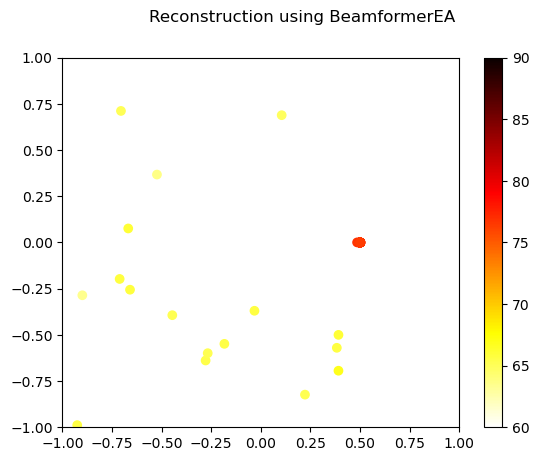

In [5]:
plt.scatter(bea._gpos[0,::],bea._gpos[1,::],c=L_p(bea.result[:,0]),cmap= 'hot_r')
plt.suptitle("Reconstruction using BeamformerEA")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.clim(60,90)
plt.colorbar()

# Old way to use BeamformerEA

76.56287890361156


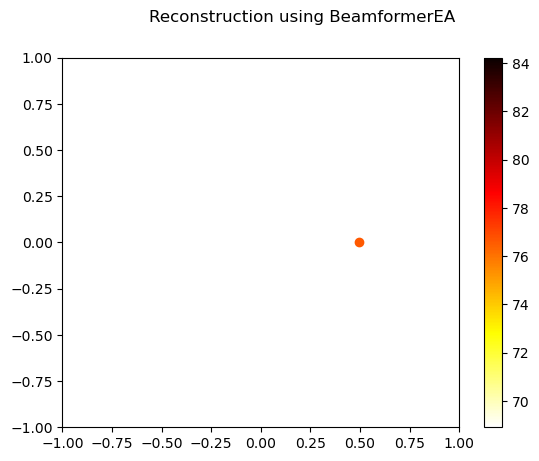

In [6]:
# An single evaluation of a small band can be made by using
# the BeamformerEA method calculate. This does not use acoular 
# cache, the fruency of the small band is passed as a parameter: 
res_BEA_o = bea.calculate(800)
# The BeamformerEA calculate method returns an scipy.optimize.OpimizeResult object, 
# in which x contains the found coordinates and strength of the sources used for reconstruction.
# In our exemplary case this would be: 
# res_BEA.x[0] - x - coordinate  source 1
# res_BEA.x[1] - y - coordinate  source 1
# res_BEA.x[2] - z - coordinate  source 1
# res_BEA.x[3] - source strength source 1

# For the graphical representation of the results only one point has to be plotted, 
# which can be achieved with pyplot.scatter.
plt.figure()
plt.scatter(res_BEA_o.x[0],res_BEA_o.x[1],c=L_p(res_BEA_o.x[3]),cmap= 'hot_r')
plt.suptitle("Reconstruction using BeamformerEA")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.colorbar()

print(L_p(res_BEA_o.x[3]))

As can be seen, the BeamformerEA finds the the source in the correct position. 

# BeamformerGridlessOrth

In [7]:
GR = RectGrid(x_min=-1,x_max=1, y_min=-1, y_max=1, z=0.75,increment=0.1)
SV = SteeringVector(grid=GR, mics=micgeom)
bgo = BeamformerGridlessOrth(freq_data=ps,steer=SV, bounds=[(-1.,1.),(-1.,1.),(0.74,0.75)])

res_bgo = bgo.synthetic(800,0)

[('Test_dat_cache.h5', 3)]


In [8]:
# Print the obtained results
print(ps.fftfreq()[:10]) # prints the small band frequencies 
print(bgo._gpos[0,:10]) # prints the x - position of the reconstructed sound source 
print(bgo._gpos[1,:10]) # prints the y - position of the reconstructed sound source 
print(bgo._gpos[2,:10]) # prints the z - position of the reconstructed sound source 
print(L_p(bgo.result[:10])) # prints the sound pressure level of the source in 1 m distance

[   0.  400.  800. 1200. 1600. 2000. 2400. 2800. 3200. 3600.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[-350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350.]
 [-350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350. -350.
  -350. -350. -350. -350. -350.]
 [-350. -350. -350. -350. -350. -350

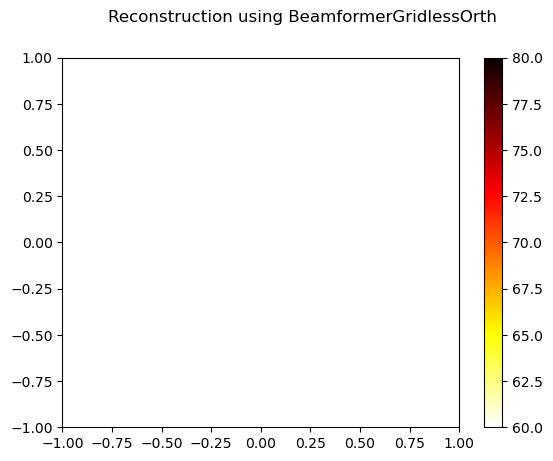

In [9]:
plt.scatter(bgo._gpos[0,::],bgo._gpos[1,::],c=L_p(bgo.result[:,0]),cmap= 'hot_r')
plt.suptitle("Reconstruction using BeamformerGridlessOrth")
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.clim(60,80)
plt.colorbar()

## BeamformerBase

[('Test_dat_cache.h5', 4)]


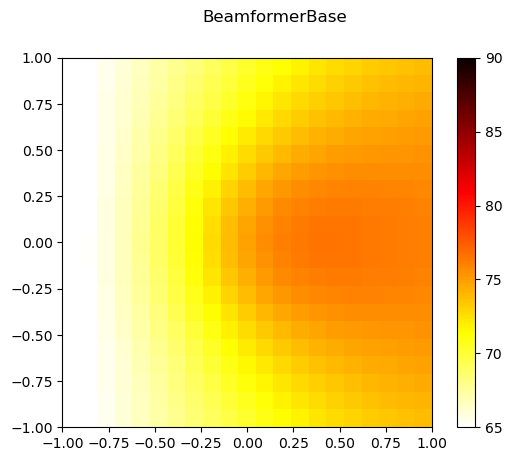

In [10]:
#define grid and steering vector for BeamformerBase and BeamformerCMF
GR = RectGrid(x_min=-1,x_max=1, y_min=-1, y_max=1, z=0.75,increment=0.1)
SV = SteeringVector(grid=GR, mics=micgeom)

beb = BeamformerBase(freq_data=ps,steer=SV)
res_BEB = beb.synthetic(800,0)

im = plt.imshow(L_p(res_BEB.T),vmax=90,vmin=65,extent=GR.extend(),cmap= 'hot_r')
plt.suptitle("BeamformerBase")
plt.colorbar()

## BeamformerCMF

[('Test_dat_cache.h5', 5)]


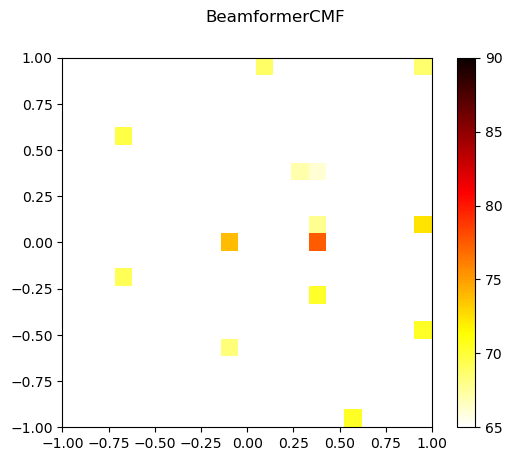

In [11]:
becmf = BeamformerCMF(freq_data=ps,steer=SV)
res_CMF = becmf.synthetic(800,0)

im = plt.imshow(L_p(res_CMF.T),vmax=90,vmin=65,extent=GR.extend(),cmap= 'hot_r')
plt.suptitle("BeamformerCMF")

plt.colorbar()

The results from BeamformerBase and BeamformerCMF are close to BeamformerEA, source position and strength are similar. Nevertheless the results are only conditionally comparable, because the BeamformerEA uses a variable grid.  